# This is a simple jupyter notebook used to investigate the profiles of various
# properties using an amrcube and disperse generated filaments

The most important part of categorizing filaments is that we generate a profile of what a specific property (ie gas density, temperature, metallicity ) look at different points in different systems. These profiles allow us to track the accretion and temperature shock across different points in the system. We use a 'kdTree' method to search for the nearest point to the filament and then preform a recursive search to find associate a gas pixel to the nearest filament segement. 


## Model Overview:
Typically when we look at either the HAGN or NH simulations at different redshifts we can extract clusters, galaxies , dark matter halos etc from these systems. If you have a generated amr2cube with a centered large cluster of galaxies as the node. The primary goal is to quantify how various physical quantities change **along and across** filaments — structures that channel matter into halos and galaxy clusters in the cosmic web.

---

## Process

### 1. Filament Identification with DisPerSE 
- DisPerSE uses persistence on a scalar field (like density) to extract filaments as critical lines (connecting saddle points to maxima). We then want to see what happens around these filaments to see if the density indeed drops out the furht er you move away from the center of the filaments. 
- It returns a skeleton file where each filament is a sequence of 3D points with orientation and persistence values.

### 2. Voxel-Based Density Representation 
- The AMR cube is stored as a 3D array of density values, `ρ(x, y, z)`, generated using `amr2cube`. This could also be in the form of metallicity or temperature etc. 


### 3. Mapping Filament Voxels Using KD-Trees
- A **k-d tree** is constructed using the 3D positions of filament points.
- Each pixel/ "voxel-type thingy" is mapped to the nearest filament segment using spatial nearest-neighbor queries.



### 4. Profile Construction
- Once voxels are assigned to filaments, properties like **density profiles** are computed:
  - **Along-filament profile**: Project pixels onto the filament spine and compute averaged properties vs. spine distance.
  - **Profile**: Measure properties (ie the density,metallicity,temp field) as a function of distance from the filament axis.

- These profiles reveal:
  - **Accretion behavior** (gas funneling toward filament axes).
  - **Shock heating patterns** across scales.
  - **Redshift-dependent evolution** of gas dynamics in the cosmic web.

---

##  Key Components in This Notebook

| Section | Functionality |
|--------|----------------|
| `fort` File Reader | Parses Fortran binary files (`.dat`) containing 3D density cubes. |
| `ReadFilament` | Parses DisPerSE filament skeletons into dictionaries. |
| `cKDTree` | Used for fast nearest-neighbor queries between gas voxels and filament spines. |
| Plotly / Matplotlib | 2D and 3D visualization of filament structures and physical profiles. |

---

## Example Workflow

```python


In [2]:
import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib as mpl
from mpl_toolkits import mplot3d
from matplotlib import cm
import mpl_toolkits.mplot3d.art3d as art3d
from scipy.spatial import cKDTree

import os
import pandas as pd
import sys  

import struct
from scipy.io import FortranFile as fort
from scipy.interpolate import interpn

mpl.rcParams['font.family'] = [ 'serif']
mpl.rcParams['agg.path.chunksize'] = 10000

import yt
from PIL import Image
import read_fils as rf
from math import ceil
# Tester Method: 
from scipy.spatial.distance import cdist

#!pip install plotly
import plotly
import plotly.io as pio
import plotly.graph_objects as go
pio.renderers.default = "notebook" 
import plotly.colors as colors

In [37]:
'''
Okay here is some basic loading up information for the different files and filaments. I am simply loading up all of
of the filaments and the gas cube as an example. We can call all of the different modules for ease of plotting but 
these can be altered to show different images or projections (along varied axes.)
'''



# Okay so the first thing you will need is an amr2cube generated gas cube. The default here is a simple HAGN cluster.
# LOADING UP THE BOX SIZE 
filename = f'/data70/cuny/sneha/snehas_first/gascube_NH_density_761_1.dat'
f4 = fort(filename, 'r')  # Assuming 'fort' is a custom function for reading Fortran binary files
size = f4.read_ints(np.int32)
rho4 = f4.read_reals('f4').reshape((size[0], size[1], size[2]), order='F')
f4.close()

# Convert pixel scale to Mpc
box_size_mpc = 20  # Total box length in Mpc change later based on the box size you extracted 
pixel_scale = box_size_mpc / size[0]  # Mpc per pixel

# Define extent for correct Mpc scaling
extent = [0, box_size_mpc, 0, box_size_mpc]  # X and Y range from 0 to 10 Mpc'

'''


# LOAD UP A DENSITY CUBE OF THE ENTIRE HAGN GAS CUBE AT THIS REDSHIFT (This is a scaling factor you can add in later) 
file_path = f'/data80/madhani/filaments/nh/NHgas.dat'
file_reader = fort(file_path, 'r')  # Assuming 'fort' is a custom function for reading Fortran binary files

cube_dimensions = file_reader.read_ints(np.int32)
density_cube = file_reader.read_reals('f4').reshape(
    (cube_dimensions[0], cube_dimensions[1], cube_dimensions[2]), order='F'
)
file_reader.close()


avg_density = np.mean(density_cube)
print(avg_density)  # Here we are going to get the average density cube value. 

'''


# Now here is how we load up one of the DisPerSe generated filaments.The standard here is to use cosmic filaments. ( See note for the analysis using the locally detected gas streams)

skeleton_file_dm_sys4 = '/data70/cuny/sneha/snehas_first/system_1_filaments_s5.up.NDskl.S005.a.NDskl'
filaments_dm_sys4 = rf.ReadFilament(skeleton_file_dm_sys4)
filament_dm_dictsys4 = filaments_dm_sys4.filament_dict
nfils = filament_dm_dictsys4['nfils']



filament_data = filament_dm_dictsys4['filaments'][:]

header1, ANDSKEL

ndims, 3

Comments, #No comments

Bounding box, BBOX [0,0,0] [1,1,1]

ncrit, 143
nfils, 103
Reading data fields:
CP field: persistence_ratio

CP field: persistence_nsigmas

CP field: persistence

CP field: persistence_pair

CP field: parent_index

CP field: parent_log_index

CP field: log_field_value

CP field: field_value

CP field: cell

Filament field: field_value

Filament field: orientation

Filament field: cell

Filament field: log_field_value

Filament field: type

Reading filaments took 14.33 secs.


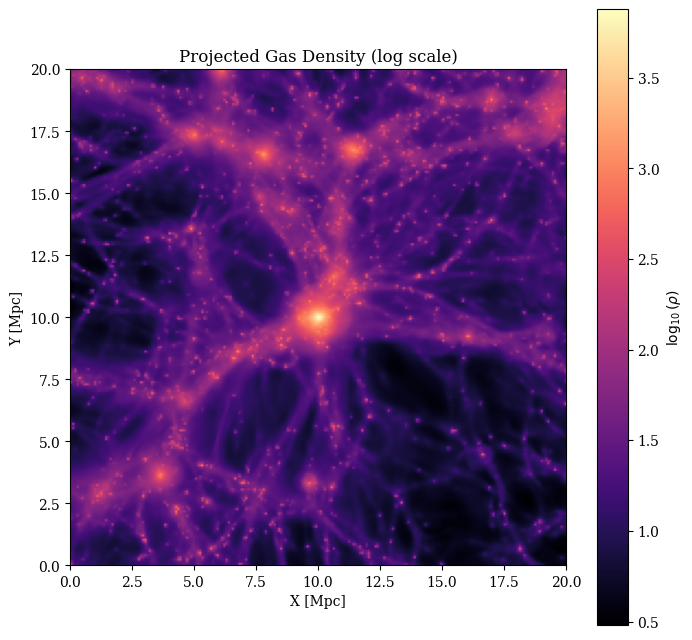

Text(0, 0.5, 'Y [Mpc]')

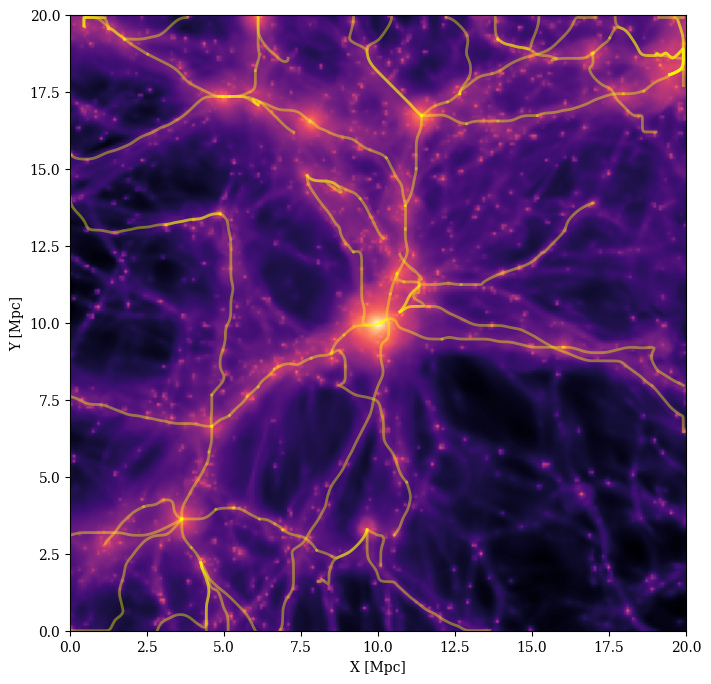

In [38]:
'''
Here is just an purely visual code block this helps people plot the filaments on top of the gas cube to ensure 
that they are properly aligned. 

'''


pixel_scale = box_size_mpc / size[0]  # Mpc per pixel

fig, ax = plt.subplots(1, 1, figsize=[8, 8])

# Project along the Z-axis
proj_rho4 = np.sum(rho4[:, :, :], axis=2)
lrho4 = np.log10(proj_rho4)

# Define extent for correct Mpc scaling
extent = [0, box_size_mpc, 0, box_size_mpc]  # X and Y range from 0 to 10 Mpc

# Plot
gas = ax.imshow(lrho4, cmap='magma', origin='lower', extent=extent)

# Labels
ax.set_xlabel("X [Mpc]")
ax.set_ylabel("Y [Mpc]")
ax.set_title("Projected Gas Density (log scale)")

# Colorbar
cbar = plt.colorbar(gas, ax=ax)
cbar.set_label(r'$\log_{10}(\rho)$')

plt.show()


def plot_dm_filament_mpc(filament_idx, filament_dict, ax, colorfil='slateblue'):
    """
    Plots a 3D filament in Mpc coordinates. not really using this one tooo much cause
    

    """
    nsamp = filament_dict['filaments'][filament_idx]['nsamp']
    positions = filament_dict['filaments'][filament_idx]['px,py,pz']

    # Convert positions from code units to Mpc
    px = []
    py = []
    pz = []

    for i in range(nsamp):
        px_, py_, pz_ = positions[i][0], positions[i][1], positions[i][2]
        px.append(px_ * box_size_mpc)
        py.append(py_ * box_size_mpc)
        pz.append(pz_ * box_size_mpc)

    ax.plot3D(px, py, pz, c=colorfil, lw=2, alpha=0.4)

    
    
def plot_dm_filament_v2_mpc(filament_idx, filament_dict, ax, colorfil='yellow'):
    """
    Plots a 2D projection of a filament in mpc coordinates. I use this on the most

    """
    nsamp = filament_dict['filaments'][filament_idx]['nsamp']
    positions = filament_dict['filaments'][filament_idx]['px,py,pz']

    # Convert positions from code units to Mpc
    px = []
    py = []

    for i in range(nsamp):
        px_, py_, _ = positions[i][0], positions[i][1], positions[i][2]
        px.append(px_ * box_size_mpc)
        py.append(py_ * box_size_mpc)

    ax.plot(py, px, c=colorfil, lw=2, alpha=0.4)  # Plot in 2D (px, py)
    
    
    
    


# Plot the density cube projection
fig, ax = plt.subplots(1, 1, figsize=[8, 8])
proj_rho = np.sum(rho4[:, :, :], axis=2)  # Summing along Z-axis
lrho = np.log10(proj_rho)

# Set extent for correct Mpc scaling
extent = [0, box_size_mpc, 0, box_size_mpc]

# Plot gas density
gas = ax.imshow(lrho, cmap='magma', origin='lower', extent=extent)

# Plot filaments in Mpc
for fil_idx in range(nfils):  # nfils is already defined in your code
    plot_dm_filament_v2_mpc(fil_idx, filament_dm_dictsys4, ax)

# Update axes to reflect Mpc scale
ax.set_xlim(0, box_size_mpc)
ax.set_ylim(0, box_size_mpc)

ax.set_xlabel('X [Mpc]')
ax.set_ylabel('Y [Mpc]')


In [49]:
'''
In this segment all that we are doing here is to follow a simple routine to process the output of the gascube and the 
disperse filaments. We want to find the coordinates of the pixel centers and then we also need to make sure that the 
filaments have been saved as a series of segments. This is how we will build a kd - tree (from the start and endpoints
of the various line segments conjoined). Please ensure that gas cube and the disperse filaments have been rescaled from
code units. 
'''

# Finding all the pixel centers:
def find_pixel_centers(image, box_size_mpc):
    """
    Find the center coordinates of each pixel in the 3D image and rescale to Mpc.

    """
    height, width, depth = image.shape
    pixel_scale = box_size_mpc / height  # Assuming a cubic box

    # Generate center coordinates
    x = (np.arange(0, width) + 0.5) * pixel_scale
    y = (np.arange(0, height) + 0.5) * pixel_scale
    z = (np.arange(0, depth) + 0.5) * pixel_scale

    xv, yv, zv = np.meshgrid(x, y, z, indexing='ij')
    centers = np.column_stack((xv.flatten(), yv.flatten(), zv.flatten()))
    
    return centers



# Compute pixel centers in Mpc
centers_mpc = find_pixel_centers(rho4, box_size_mpc)

# Print the number of pixel centers
print(f"Total number of pixel centers: {len(centers_mpc)}")
print(f"First few pixel centers (in Mpc):\n{centers_mpc[:5]}")


# Now that we have stored all of the pixel center coordinates, let's now build the filaments. 

def build_segments_from_filament(filament_data, box_size_mpc):
    """
    Given a list of filaments' px,py,pz arrays, this function builds
    the start and end point segments for each filament in Mpc units.
    
    """
    all_segments = []

    # Loop through each filament
    for filament in filament_data:
        # Extract the array of 3D points
        points = np.array(filament['px,py,pz'])  # Shape: (num_points, 3)
        
        # Convert from code units to Mpc
        points_mpc = points * box_size_mpc  # Scaling each coordinate

        # Create line segments between consecutive points
        segments = np.array([[points_mpc[i], points_mpc[i+1]] for i in range(len(points_mpc) - 1)])
        
        # Append to all segments
        all_segments.append(segments)

    # Return all segments as a single array
    return np.concatenate(all_segments, axis=0) if all_segments else np.array([])

# Process filaments and collect their segments in Mpc
all_filament_segments_mpc = build_segments_from_filament(filament_data, box_size_mpc)


print(f"Total segments: {len(all_filament_segments_mpc)}")
print("First few segments (in Mpc):\n", all_filament_segments_mpc[:3])



def closest_point_on_segment(segment_start, segment_end, point):
    segment_vector = segment_end - segment_start
    point_vector = point - segment_start
    t = np.dot(point_vector, segment_vector) / np.dot(segment_vector, segment_vector)
    t = np.clip(t, 0, 1)
    return segment_start + t * segment_vector



## Now here is a function that sorts out the critical points and we can pull out the node to saddle ciritcal points.
def extract_node_to_saddle_filaments(filament_dict, box_size_mpc, target=np.array([10, 10, 10]), save_path=None):
    """
    Extracts a mapping from node critical points to saddle critical points 
    via filament segments from the given filament data dictionary.
    """

    def cp_tuple(cp, scale=1.0):
        return (round(cp['px'] * scale, 6), round(cp['py'] * scale, 6), round(cp['pz'] * scale, 6))

    # Separate critical points
    critical_points = filament_dict['critical_points']
    nodes = [cp for cp in critical_points if cp['cp_idx'] == 3.0]
    saddles = [cp for cp in critical_points if cp['cp_idx'] == 2.0]

    # Scale coordinates
    node_coords = np.array([[cp['px'], cp['py'], cp['pz']] for cp in nodes]) * box_size_mpc
    saddle_coords = np.array([[cp['px'], cp['py'], cp['pz']] for cp in saddles]) * box_size_mpc

    # Find closest node to target
    distances = np.linalg.norm(node_coords - target, axis=1)
    closest_idx = np.argmin(distances)
    closest_cp = nodes[closest_idx]
    cn_x, cn_y, cn_z = node_coords[closest_idx]

    print("Closest node critical point:", closest_cp)
    print("Closest node coordinates:", (cn_x, cn_y, cn_z))

    # Build lookup sets for node and saddle point coordinates
    node_coords_set = {cp_tuple(cp, scale=box_size_mpc) for cp in nodes}
    saddle_coords_set = {cp_tuple(cp, scale=box_size_mpc) for cp in saddles}

    # Build node-to-saddle filament map
    node_to_saddle_filaments = {}

    for filament in filament_dict['filaments']:
        positions = np.array(filament['px,py,pz']) * box_size_mpc

        if len(positions) < 2:
            continue

        start = tuple(np.round(positions[0], 6))
        end = tuple(np.round(positions[-1], 6))

        if start in node_coords_set and end in saddle_coords_set:
            node, saddle = start, end
        elif end in node_coords_set and start in saddle_coords_set:
            node, saddle = end, start
            positions = positions[::-1]
        else:
            continue  # Not a node-saddle filament

        # Convert to line segments
        segments = [np.array([positions[i], positions[i + 1]]) for i in range(len(positions) - 1)]

        if node not in node_to_saddle_filaments:
            node_to_saddle_filaments[node] = {}
        if saddle not in node_to_saddle_filaments[node]:
            node_to_saddle_filaments[node][saddle] = []

        node_to_saddle_filaments[node][saddle].extend(segments)

    # Save to pickle if requested
    if save_path:
        with open(save_path, 'wb') as f:
            pickle.dump(node_to_saddle_filaments, f)
        print(f"Saved node-to-saddle map to {save_path}")

    return node_to_saddle_filaments

Total number of pixel centers: 11645554
First few pixel centers (in Mpc):
[[0.04405286 0.04405286 0.04405286]
 [0.04405286 0.04405286 0.13215859]
 [0.04405286 0.04405286 0.22026432]
 [0.04405286 0.04405286 0.30837004]
 [0.04405286 0.04405286 0.39647577]]
Total segments: 3167
First few segments (in Mpc):
 [[[16.72566 15.177    8.84956]
  [16.75988 15.26548  8.84956]]

 [[16.75988 15.26548  8.84956]
  [16.78698 15.35398  8.84956]]

 [[16.78698 15.35398  8.84956]
  [16.80366 15.44248  8.84956]]]


In [40]:
'''
Here we now have all of the different profiling routines. Since most cubes will contain a number of pixels on the 
order of magnitude of $10^{6}$ we process the data in chunks. You can choose to have consectuive plotting so you 
can see the plotting as it happens. 

Plots a simple density /temperature/metallicty profile using a 2000 kpc around each filament as 
the region of interest. These profiles are then stacked across all the FILAMENTs and plotted. 

'''


def stacked_filament_profile_plots(
    centers_mpc,
    rho4,
    all_filament_segments_mpc,
    closest_point_on_segment,
    output_csv='chunked_density_results.csv',
    box_radius_mpc=2.0,
    chunk_size=100000,
    show_plots=True
):
    """
    Processes centers and densities in chunks, finds closest filament segment,
    and computes average density in  bins.

    """
    mpc_to_kpc = 1000
    box_radius_kpc = box_radius_mpc * mpc_to_kpc
    num_chunks = ceil(len(centers_mpc) / chunk_size)
    all_data = []
    segment_midpoints2 = np.mean(all_filament_segments_mpc, axis=1)
    tree_segs = cKDTree(segment_midpoints2)

    for chunk_idx in range(num_chunks):
        start_idx = chunk_idx * chunk_size
        end_idx = min((chunk_idx + 1) * chunk_size, len(centers_mpc))
        center_chunk = centers_mpc[start_idx:end_idx]
        rho_flat = rho4.flatten()
        distances_points, indices = tree_segs.query(center_chunk)

        data = []

        for i, center in enumerate(center_chunk):
            segment_index = indices[i]
            segment_start = all_filament_segments_mpc[segment_index][0]
            segment_end = all_filament_segments_mpc[segment_index][1]
            closest_point = closest_point_on_segment(segment_start, segment_end, center)
            distance_mpc = np.linalg.norm(center - closest_point)
            distance_kpc = distance_mpc * mpc_to_kpc

            if np.all(np.abs(center - closest_point) <= box_radius_mpc) and distance_mpc <= box_radius_mpc:
                data.append({
                    'query_point': center,
                    'density_value': rho_flat[start_idx + i],
                    'closest_segment_start': segment_start,
                    'closest_segment_end': segment_end,
                    'closest_point': closest_point,
                    'distance_kpc': distance_kpc
                })

        all_data.extend(data)

        if not data:
            print(f"Skipping chunk {chunk_idx + 1} as no points were within the {box_radius_kpc} kpc box.")
            continue

        df = pd.DataFrame(data)
        if df.empty:
            print(f"Chunk {chunk_idx + 1} resulted in an empty DataFrame. Skipping.")
            continue

        distances = df['distance_kpc']
        density_values = df['density_value']

        hist, bin_edges = np.histogram(distances, bins=25)
        average_densities = []
        bin_centers = []

        for i in range(len(bin_edges) - 1):
            bin_mask = (distances >= bin_edges[i]) & (distances < bin_edges[i + 1])
            if np.any(bin_mask):
                avg_density = np.mean(density_values[bin_mask])
                average_densities.append(avg_density)
                bin_centers.append((bin_edges[i] + bin_edges[i + 1]) / 2)

        if show_plots:
            plt.figure(figsize=(10, 6))
            plt.plot(bin_centers, average_densities, marker='o', linestyle='-', color='red', label=f'Chunk {chunk_idx + 1}')
            plt.title(f'Average Density vs Distance (Chunk {chunk_idx + 1})')
            plt.xlabel('Distance [kpc]')
            plt.ylabel('Average Density')
            plt.yscale('log')
            plt.grid()
            plt.legend()
            plt.show()

    if all_data:
        final_df = pd.DataFrame(all_data)
        final_df.to_csv(output_csv, index=False)
        print(f"Saved results to {output_csv}")
        return final_df
    else:
        print("No data was collected across all chunks.")
        return pd.DataFrame()
    


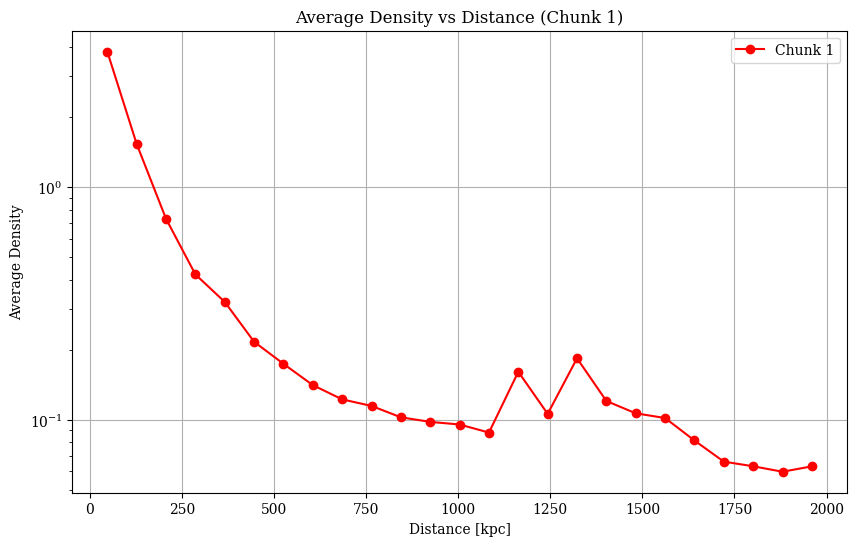

KeyboardInterrupt: 

In [29]:
stacked_filament_profile_plots(
    centers_mpc,
    rho4,
    all_filament_segments_mpc,
    closest_point_on_segment,
    output_csv='chunked_density_results.csv',
    box_radius_mpc=2.0,
    chunk_size=100000,
    show_plots=True
)

# Now let's process them individually so we can see what's going on:


In [50]:
node_to_saddle_filaments = extract_node_to_saddle_filaments(filament_dm_dictsys4, box_size_mpc, target=np.array([10, 10, 10]), save_path=None)

Closest node critical point: {'cp_idx': 3.0, 'px': 0.5, 'py': 0.504425, 'pz': 0.517699, 'pair_ID': 5.0, 'boundary': 0.0, 'nfil': 5, 'destID,filID': [[35, 5], [38, 11], [40, 14], [49, 32], [73, 72]], 'Field Vals': [-1.0, -1.0, 1.797693e+308, 5.0, -1.0, -1.0, inf, inf, 6001769.0]}
Closest node coordinates: (10.0, 10.0885, 10.35398)


In [42]:
def plot_critical_points_on_density(
    rho4,
    box_size_mpc,
    filament_dm_dictsys4,
    save_path='density_with_critical_points.png',
    target_coord_mpc=np.array([10, 10, 10])
):
    """
    Generate and save a gas density projection image with critical points (nodes & saddles) overlaid.

    Parameters
    ----------
    rho4 : ndarray
        3D array of gas density values (assumed shape: [Nx, Ny, Nz]).
    box_size_mpc : float
        Size of the simulation box in Mpc.
    filament_dm_dictsys4 : dict
        Dictionary containing 'critical_points' with position info and type info.
    save_path : str
        Filename to save the image to.
    target_coord_mpc : array_like
        3D coordinate (in Mpc) near which the central node will be highlighted.
    """

    # Project gas density along z-axis
    proj_rho = np.sum(rho4, axis=2)
    log_rho = np.log10(proj_rho + 1e-12)

    # Setup figure
    fig, ax = plt.subplots(figsize=(8, 8))
    extent = [0, box_size_mpc, 0, box_size_mpc]
    im = ax.imshow(log_rho, origin='lower', extent=extent, cmap='magma')

    # Extract critical points
    critical_points = filament_dm_dictsys4.get("critical_points", [])
    nodes = [cp for cp in critical_points if cp["cp_idx"] == 3.0]
    saddles = [cp for cp in critical_points if cp["cp_idx"] == 2.0]

    # Convert to Mpc coordinates
    node_coords = np.array([[cp["px"], cp["py"], cp["pz"]] for cp in nodes]) * box_size_mpc
    saddle_coords = np.array([[cp["px"], cp["py"], cp["pz"]] for cp in saddles]) * box_size_mpc

    # Scatter plot critical points
    ax.scatter(node_coords[:, 1], node_coords[:, 0], c='red', s=20, label='Nodes')
    ax.scatter(saddle_coords[:, 1], saddle_coords[:, 0], c='white', s=20, label='Saddles')

    # Find and mark central node
    if len(node_coords) > 0:
        dists = np.linalg.norm(node_coords - target_coord_mpc, axis=1)
        closest_idx = np.argmin(dists)
        central_node = node_coords[closest_idx]
        ax.scatter(central_node[1], central_node[0], c='cyan', s=50, label='Central Node')
     
    for fil_idx in range(nfils):  # nfils is already defined in your code
        plot_dm_filament_v2_mpc(fil_idx, filament_dm_dictsys4, ax)

      

    # Final plot adjustments
    ax.set_xlabel("Y [Mpc]")
    ax.set_ylabel("X [Mpc]")
    ax.set_title("Gas Density Projection with Critical Points")
    ax.legend()
    cbar = fig.colorbar(im, ax=ax)
    cbar.set_label("log₁₀(ρ)")
    plt.tight_layout()
    plt.savefig(save_path)
    plt.show()
    plt.close()

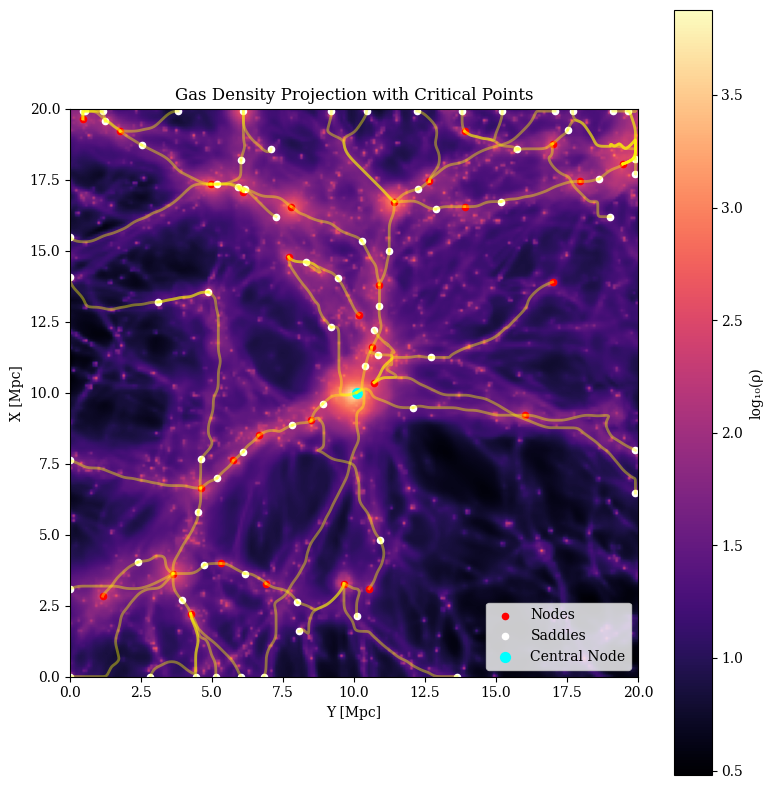

In [43]:
plot_critical_points_on_density(
    rho4=rho4,
    box_size_mpc=20.0,
    filament_dm_dictsys4=filament_dm_dictsys4,
    save_path='filament_42_density_with_cps.png'
)

In [44]:
def process_filament_density_profiles_one_by_one_slower(
    node_to_saddle_filaments,
    centers_mpc,
    rho4,
    box_size_mpc,
    save_csv_path='dataset_all_filaments_TEMP.csv',
    chunk_size=100000,
    box_radius_mpc=2.0,
    filament_dm_dictsys4=None
):
    """
    Processes density-distance profiles for all filaments in node_to_saddle_filaments
    and overlays each one on a projected gas density map.

    """
    mpc_to_kpc = 1000
    box_radius_kpc = box_radius_mpc * mpc_to_kpc
    rho_flat = rho4.flatten()
    global_data = []

    def create_line_segments(selected_segments):
        all_segments = []
        selected_segments = np.array(selected_segments)
        segments = np.array([[selected_segments[i], selected_segments[i + 1]]
                             for i in range(len(selected_segments) - 1)])
        all_segments.append(segments)
        return np.concatenate(all_segments, axis=0) if all_segments else np.array([])

    def closest_point_on_segment(A, B, P):
        AP = P - A
        AB = B - A
        t = np.dot(AP, AB) / np.dot(AB, AB)
        t = np.clip(t, 0, 1)
        return A + t * AB

    def plot_dm_filament_v2_mpc(filament_idx, filament_dict, ax, colorfil='yellow'):
        nsamp = filament_dict['filaments'][filament_idx]['nsamp']
        positions = filament_dict['filaments'][filament_idx]['px,py,pz']
        px, py = [], []
        for i in range(nsamp):
            px_, py_, _ = positions[i][0], positions[i][1], positions[i][2]
            px.append(px_ * box_size_mpc)
            py.append(py_ * box_size_mpc)
        ax.plot(py, px, c=colorfil, lw=2, alpha=0.6)

    for key_idx, node in enumerate(node_to_saddle_filaments.keys()):
        print(f"Processing Filament {key_idx + 1}...")

        selected_segments = []
        for saddle, segments in node_to_saddle_filaments[node].items():
            selected_segments.extend(segments)

        if len(selected_segments) < 2:
            continue

        all_segments = create_line_segments(selected_segments)
        all_segments = np.concatenate(all_segments, axis=0)
        segment_midpoints = np.mean(all_segments, axis=1)
        tree_segs = cKDTree(segment_midpoints)

        filament_data = []
        num_chunks = ceil(len(centers_mpc) / chunk_size)
        for chunk_idx in range(num_chunks):
            start_idx = chunk_idx * chunk_size
            end_idx = min((chunk_idx + 1) * chunk_size, len(centers_mpc))
            center_chunk = centers_mpc[start_idx:end_idx]
            distances_points, indices = tree_segs.query(center_chunk)

            for i, center in enumerate(center_chunk):
                seg_idx = indices[i]
                seg_start, seg_end = all_segments[seg_idx]
                closest = closest_point_on_segment(seg_start, seg_end, center)
                dist_mpc = np.linalg.norm(center - closest)
                dist_kpc = dist_mpc * mpc_to_kpc

                if np.all(np.abs(center - closest) <= box_radius_mpc) and dist_mpc <= box_radius_mpc:
                    filament_data.append({
                        'query_point': center,
                        'density_value': rho_flat[start_idx + i],
                        'closest_segment_start': seg_start,
                        'closest_segment_end': seg_end,
                        'closest_point': closest,
                        'distance_kpc': dist_kpc
                    })

        if filament_data:
            df = pd.DataFrame(filament_data)

            # Histogram binning
            distances = df['distance_kpc']
            density_values = df['density_value']
            hist, bin_edges = np.histogram(distances, bins=25)

            average_densities = []
            bin_centers = []

            for i in range(len(bin_edges) - 1):
                mask = (distances >= bin_edges[i]) & (distances < bin_edges[i + 1])
                if np.any(mask):
                    avg_density = np.mean(density_values[mask])
                    average_densities.append(avg_density)
                    bin_centers.append((bin_edges[i] + bin_edges[i + 1]) / 2)

            # Plot 1D profile
            plt.figure(figsize=(10, 6))
            plt.plot(bin_centers, average_densities, marker='o', linestyle='-', color='red',
                     label=f'Filament {key_idx + 1}')
            plt.title(f'Average Density vs. Distance (Filament {key_idx + 1})')
            plt.xlabel('Distance [kpc]')
            plt.ylabel('Average Density')
            plt.yscale('log')
            plt.grid()
            plt.legend()
            plt.savefig(f'filament_{key_idx + 1}_Metallicity.png')
            plt.close()

            # Plot 2D overlay
            fig, ax = plt.subplots(1, 1, figsize=[8, 8])
            proj_rho = np.sum(rho4, axis=2)
            lrho = np.log10(proj_rho)
            extent = [0, box_size_mpc, 0, box_size_mpc]
            img = ax.imshow(lrho, cmap='magma', origin='lower', extent=extent)

            if filament_dm_dictsys4 is not None:
                for fil_idx in range(len(filament_dm_dictsys4['filaments'])):
                    color = 'cyan' if fil_idx == key_idx else 'yellow'
                    plot_dm_filament_v2_mpc(fil_idx, filament_dm_dictsys4, ax, colorfil=color)

            ax.set_xlabel("X [Mpc]")
            ax.set_ylabel("Y [Mpc]")
            ax.set_title(f"Filament {key_idx + 1} on Projected Gas Density")
            cbar = plt.colorbar(img, ax=ax)
            cbar.set_label(r'$\log_{10}(\rho)$')
            plt.savefig(f'filament_{key_idx + 1}_overlay.png')
            plt.close()

            global_data.extend(filament_data)
        else:
            print(f"No data collected for Filament {key_idx + 1}.")
 
    # Save combined dataset
    if global_data:
        final_df = pd.DataFrame(global_data)
        final_df.to_csv(save_csv_path, index=False)
        print(f"Final data saved to {save_csv_path}")
    else:
        print("No data was collected across all filaments.")

In [21]:
process_filament_density_profiles_one_by_one_slower(
    node_to_saddle_filaments,
    centers_mpc,
    rho4,
    box_size_mpc,
    save_csv_path='output_all_filaments.csv',
    chunk_size=100000,
    box_radius_mpc=2.0,
    filament_dm_dictsys4=filament_dm_dictsys4
)

Processing Filament 1...
Processing Filament 2...
No data was collected across all filaments.


In [45]:

def show_filament_overlay_interactive(rho4, box_size_mpc, filament_dm_dictsys4):
    """
    Display interactive overlay of filaments on gas projection using plotly.
    Hovering over a filament shows its ID.
    """
    proj_rho = np.sum(rho4, axis=2)
    lrho = np.log10(proj_rho)
    size = lrho.shape[0]
    pixel_scale = box_size_mpc / size

    # x and y axis values
    x_vals = np.linspace(0, box_size_mpc, size)
    y_vals = np.linspace(0, box_size_mpc, size)

    # Plot with explicit x and y coordinates
    fig = go.Figure()

    fig.add_trace(go.Heatmap(
        z=lrho,
        x=x_vals,  # Maps columns to Mpc values
        y=y_vals,  # Maps rows to Mpc values
        colorscale='Magma',
        colorbar=dict(title='log10(ρ)'),
        showscale=True
    ))

    fig.update_layout(
        title="Projected Gas Density",
        xaxis_title="X [Mpc]",
        yaxis_title="Y [Mpc]",
        yaxis=dict(scaleanchor="x", scaleratio=1),  # ensures square pixels
    )

    fig.show()

    for fil_idx, filament in enumerate(filament_dm_dictsys4['filaments']):
        nsamp = filament['nsamp']
        positions = filament['px,py,pz']
        xs = [positions[i][0] * box_size_mpc for i in range(nsamp)]
        ys = [positions[i][1] * box_size_mpc for i in range(nsamp)]

        fig.add_trace(go.Scatter(
            x=ys,
            y=xs,
            mode='lines+markers',
            line=dict(width=2),
            marker=dict(size=4),
            name=f"Filament {fil_idx}",
            hovertemplate=f"Filament ID: {fil_idx}<extra></extra>",
            showlegend=False
        ))

    fig.update_layout(
        title="Hover over filaments to see IDs",
        xaxis_title="Y [Mpc]",
        yaxis_title="X [Mpc]",
        width=800,
        height=800
    )

    fig.show()
    

    

def choosen_single_filament_density_profile(
    filament_id,
    flat_filaments,
    centers_mpc,
    rho4,
    box_size_mpc,
    save_csv_path='dataset_single_filament_TEMP.csv',
    chunk_size=100000,
    box_radius_mpc=0.002,  # 2 kpc = 0.002 Mpc
    filament_dm_dictsys4=None
):
    """
    Process density-distance profile for a single filament after interactive selection.

    """
    mpc_to_kpc = 1000
    box_radius_kpc = box_radius_mpc * mpc_to_kpc
    

    def create_line_segments(selected_points):
        segments = np.array([[selected_points[i], selected_points[i + 1]]
                             for i in range(len(selected_points) - 1)])
        return segments

    def closest_point_on_segment(A, B, P):
        AP = P - A
        AB = B - A
        t = np.dot(AP, AB) / np.dot(AB, AB)
        t = np.clip(t, 0, 1)
        return A + t * AB

        # Select filament points by filament_id using flat_filaments
    all_keys = list(flat_filaments.keys())
    print(len(all_keys))

    if filament_id not in flat_filaments:
        print("Invalid filament ID")
        return

    selected_points = []
    # flat_filaments[filament_id]['segments'] is a list of arrays (segments)
    for segment in flat_filaments[filament_id]['segments']:
        selected_points.extend(segment)

    if len(selected_points) < 2:
        print("Selected filament too short.")
        return

    selected_points = np.array(selected_points)  # (N, 3) array
    
    
    
    

    min_bounds = np.min(selected_points, axis=0) - box_radius_mpc
    max_bounds = np.max(selected_points, axis=0) + box_radius_mpc
    print(min_bounds,max_bounds)

    in_box_mask = np.all((centers_mpc >= min_bounds) & (centers_mpc <= max_bounds), axis=1)
    # Filter centers_mpc within bounding box to reduce data size
    #in_box_mask = np.all((centers_mpc >= min_bounds) & (centers_mpc <= max_bounds), axis=1)
    filtered_centers = centers_mpc[in_box_mask]

    # Flatten rho4 and filter accordingly
    rho_flat = rho4.flatten()
    rho_filtered = rho_flat[in_box_mask]

    if len(filtered_centers) == 0:
        print("No pixel centers found near the filament bounding box.")
        return

    all_segments = create_line_segments(selected_points)
    segment_midpoints = np.mean(all_segments, axis=1)
    tree_segs = cKDTree(segment_midpoints)

    filament_data = []
    num_chunks = ceil(len(filtered_centers) / chunk_size)

    for chunk_idx in range(num_chunks):
        start_idx = chunk_idx * chunk_size
        end_idx = min((chunk_idx + 1) * chunk_size, len(filtered_centers))
        center_chunk = filtered_centers[start_idx:end_idx]
        rho_chunk = rho_filtered[start_idx:end_idx]

        distances_points, indices = tree_segs.query(center_chunk)

        for i, center in enumerate(center_chunk):
            seg_idx = indices[i]
            seg_start, seg_end = all_segments[seg_idx]
            closest = closest_point_on_segment(seg_start, seg_end, center)
            dist_mpc = np.linalg.norm(center - closest)
            dist_kpc = dist_mpc * mpc_to_kpc

            if dist_mpc <= box_radius_mpc:
                filament_data.append({
                    'query_point': center,
                    'density_value': rho_chunk[i],
                    'closest_segment_start': seg_start,
                    'closest_segment_end': seg_end,
                    'closest_point': closest,
                    'distance_kpc': dist_kpc
                })

    if filament_data:
        df = pd.DataFrame(filament_data)

        distances = df['distance_kpc']
        density_values = df['density_value']
        hist, bin_edges = np.histogram(distances, bins=25)

        average_densities = []
        bin_centers = []

        for i in range(len(bin_edges) - 1):
            mask = (distances >= bin_edges[i]) & (distances < bin_edges[i + 1])
            if np.any(mask):
                avg_density = np.mean(density_values[mask])
                average_densities.append(avg_density)
                bin_centers.append((bin_edges[i] + bin_edges[i + 1]) / 2)

        plt.figure(figsize=(10, 6))
        plt.plot(bin_centers, average_densities, marker='o', linestyle='-', color='red',
                 label=f'Filament {filament_id}')
        plt.title(f'Average Density vs. Distance (Filament {filament_id})')
        plt.xlabel('Distance [kpc]')
        plt.ylabel('Average Density')
        plt.yscale('log')
        plt.grid()
        plt.legend()
        plt.savefig(f'filament_{filament_id}_Density.png')
        plt.close()

        df.to_csv(save_csv_path, index=False)
        print(f"Filament {filament_id} data saved to {save_csv_path}")
        print(f"Filament {filament_id} data saved to filament_{filament_id}_Density.png")
    else:
        print(f"No data collected for Filament {filament_id}.")
        
        

        

In [51]:
node_to_saddle_filaments = extract_node_to_saddle_filaments(filament_dm_dictsys4, box_size_mpc, target=np.array([10, 10, 10]), save_path=None)
#print(len(node_to_saddle_filaments.keys()))
def restructure_filaments(node_to_saddle_filaments):
    new_dict = {}
    filament_idx = 0

    for node_coord, saddle_dict in node_to_saddle_filaments.items():
        for saddle_coord, segments in saddle_dict.items():
            new_dict[filament_idx] = {
                "start": node_coord,
                "end": saddle_coord,
                "segments": segments
            }
            filament_idx += 1

    return new_dict
flat_filaments = restructure_filaments(node_to_saddle_filaments)
#print(len(flat_filaments.keys()))


Closest node critical point: {'cp_idx': 3.0, 'px': 0.5, 'py': 0.504425, 'pz': 0.517699, 'pair_ID': 5.0, 'boundary': 0.0, 'nfil': 5, 'destID,filID': [[35, 5], [38, 11], [40, 14], [49, 32], [73, 72]], 'Field Vals': [-1.0, -1.0, 1.797693e+308, 5.0, -1.0, -1.0, inf, inf, 6001769.0]}
Closest node coordinates: (10.0, 10.0885, 10.35398)
33
103


In [52]:
show_filament_overlay_interactive(rho4, box_size_mpc, filament_dm_dictsys4)

In [53]:

filament_id=5
choosen_single_filament_density_profile(
    filament_id=filament_id,
    flat_filaments=flat_filaments,
    centers_mpc=centers_mpc,
    rho4=rho4,
    box_size_mpc=box_size_mpc,
    save_csv_path=f'filament_{filament_id}_density_profile.csv',
    chunk_size=100000,      # adjust as needed for memory
    box_radius_mpc=2   # 2 Mpc radius around filament segments in Mpc
)

103
[13.       9.23894  7.64602] [18.72566 13.41592 12.66372]


/tmp/ipykernel_225108/533202848.py:93: RuntimeWarning:

invalid value encountered in scalar divide



Filament 20 data saved to filament_20_density_profile.csv
Filament 20 data saved to filament_20_Density.png
